## Computer Vision Model
Project Link: [Computer Vision Project](https://github.com/Jubin1122/Competition_ComputerVisionModel.git)

The submission file link: [Output](https://github.com/Jubin1122/Competition_ComputerVisionModel/tree/master/output)

Model output: [link](https://drive.google.com/drive/folders/1xlTleYUVZ4gEXzw2odhL3X2D1c1FJsYG?usp=sharing)


## For loading:
new_model = tf.keras.models.load_model('my_model')
## Check its architecture
new_model.summary()

In [17]:
import os
import glob
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import warnings
#warnings.filterwarnings("ignore")
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# shutil.rmtree('/content/training_logs', ignore_errors=True)

In [ ]:

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


## Investigation of the data

In [3]:
path = '/content/drive/MyDrive/XYZ_Company/Dataset'
classes = os.listdir(os.path.join(path +'/Training'))
print('All Classes:', classes)


All Classes: ['Table', 'Bicycle', 'Cat', 'People', 'Boat', 'Motorbike']


In [4]:
# Printing total images in train test folder


test = [i for i in glob.glob('/content/drive/MyDrive/XYZ_Company/Dataset/Testing/*')]
train = glob.glob('/content/drive/MyDrive/XYZ_Company/Dataset/Training/**/*.jpg', recursive=True)
validation = glob.glob('/content/drive/MyDrive/XYZ_Company/Dataset/Validation/**/*.jpg', recursive=True)


print(f'Total train images:{len(train)}')
print(f'Total validation images:{len(validation)}')
print(f'Total test images:{len(validation)}')

Total train images:1426
Total validation images:401
Total test images:401


In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/XYZ_Company/AI_Basic_Test/train.csv')
df_val = pd.read_csv('/content/drive/MyDrive/XYZ_Company/AI_Basic_Test/val.csv')
df_test = pd.read_csv('/content/drive/MyDrive/XYZ_Company/AI_Basic_Test/test_set.csv')
df_test.head()

,Image_Path,Class
0,Testing/2015_00417.jpg,NaN
1,Testing/2015_07261.jpg,NaN
2,Testing/2015_01083.jpg,NaN
3,Testing/2015_06722.jpg,NaN
4,Testing/2015_01124.jpg,NaN


(511, 335, 3)
(511, 335, 3)


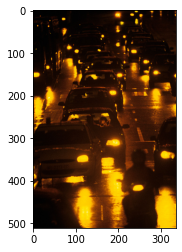

In [6]:
obj_img = imread(os.path.join(path, df_train['Image_Path'][0]))
image = cv2.cvtColor(obj_img, cv2.COLOR_BGR2RGB).astype(np.float32)
print(image.shape)
plt.imshow(obj_img)
print(obj_img.shape)

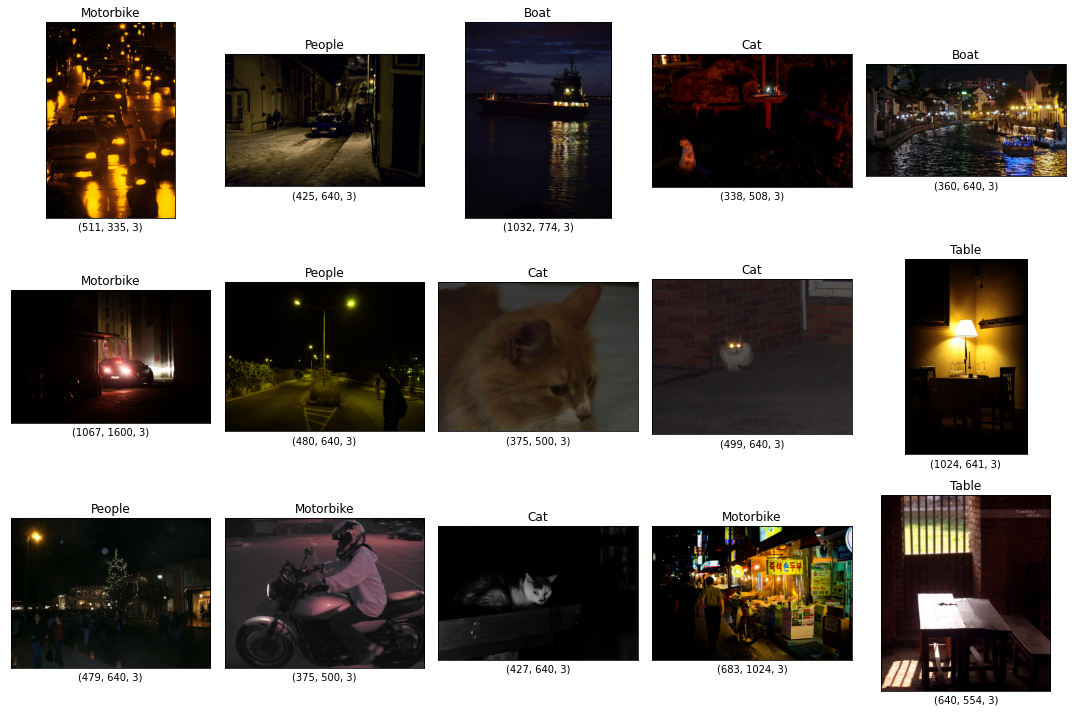

In [7]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(os.path.join(path, df_train['Image_Path'][i])))
    ax.set_title(df_train['Class'][i])
    img_size = imread(os.path.join(path, df_train['Image_Path'][i]))
    ax.set_xlabel(img_size.shape)

plt.tight_layout()
plt.show()

### Min and max image dimension

In [8]:
from PIL import Image
ar  = []
for i in df_train['Image_Path'].values:
  ar.append(Image.open(os.path.join(path,i) , 'r').size)

In [9]:
print(f'max image dimension: {max(ar)}\n min image dimension: {min(ar)}')

max image dimension: (4288, 2848)
 min image dimension: (281, 500)


### Checking Class distibution

In [10]:
display(df_train.groupby('Class').count())
display(df_val.groupby('Class').count())

,Image_Path
Class,
Bicycle,240
Boat,240
Cat,240
Motorbike,240
People,240
Table,240


,Image_Path
Class,
Bicycle,80
Boat,80
Cat,80
Motorbike,80
People,80
Table,80


In [15]:
# Training Set
total = 0
train_path = os.path.join(path,'Training')
print('Training Set\n')
for i in os.listdir(train_path):
  x = os.listdir(os.path.join(train_path,i))
  print(f'{i}:- {len(x)}\n')
  total += len(x)

print(f'Total images: {total}')

Training Set

Table:- 240

Bicycle:- 240

Cat:- 240

People:- 240

Boat:- 240

Motorbike:- 240

Total images: 1440


In [16]:
# Validation Set
total = 0
val_path = os.path.join(path,'Validation')
print('Validation Set\n')
for i in os.listdir(val_path):
  x = os.listdir(os.path.join(val_path,i))
  print(f'{i}:- {len(x)}\n')
  total += len(x)

print(f'Total images: {total}')


Validation Set

Motorbike:- 80

Cat:- 80

People:- 80

Table:- 80

Boat:- 80

Bicycle:- 80

Total images: 480


## Data Preprocessing

In [ ]:
# The images will all be resized to this size.

# train_dir
train_dir = os.path.join(path, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(path, 'val_dir')
os.mkdir(val_dir)

# test_dir
test_dir = os.path.join(path, 'test_dir')
os.mkdir(test_dir)

In [ ]:
# create new folders inside train_dir

for sub_fol in classes:
    
    folder = os.path.join(train_dir, str(sub_fol))
    os.mkdir(folder)


# create new folders inside val_dir

for sub_fol in classes:
    
    folder = os.path.join(val_dir, str(sub_fol))
    os.mkdir(folder)

In [ ]:
class reshape:

  def __init__(self, source_path, path, df, img_size):
    self.source_path = source_path
    self.path = path
    self.df = df
    self.img_size = img_size

  def reshape(self):
    for i in self.df['Image_Path'].values:
      
      cls = i.split('/')[1]
      img_nm = i.split('/')[2]
      if cls in os.listdir(self.path):
        src_path =  os.path.join(self.source_path,i)
        dst_path =  os.path.join(self.path,cls,img_nm)
      
      # resize and save it into another location
      image = cv2.imread(src_path)
      image = cv2.resize(image, (self.img_size, self.img_size))
      # save the image at the destination
      cv2.imwrite(dst_path, image)

  def test_reshape(self):
    for i in self.df['Image_Path'].values:
      img_nm = i.split('/')[1]
      src_path =  os.path.join(self.source_path,i)
      dst_path =  os.path.join(self.path,img_nm)

      # resize and save it into another location
      image = cv2.imread(src_path)
      image = cv2.resize(image, (self.img_size, self.img_size))
      # save the image at the destination
      cv2.imwrite(dst_path, image)   

In [ ]:
train_path  = '/content/drive/MyDrive/XYZ_Company/Dataset/train_dir'
image_size = 224
obj = reshape(path, train_path, df_train, image_size)
print(obj.reshape())

None


In [ ]:
val_path  = '/content/drive/MyDrive/XYZ_Company/Dataset/val_dir'
obj = reshape(path, val_path, df_val, image_size)
print(obj.reshape())

None


In [ ]:
test_path  = '/content/drive/MyDrive/XYZ_Company/Dataset/test_dir'
image_size = 299
obj = reshape(path, test_path, df_test, image_size)
print(obj.test_reshape())

None


In [ ]:
total = 0
train_path = os.path.join(path,'train_dir')
for i in os.listdir(train_path):
  x = os.listdir(os.path.join(train_path,i))
  print(f'{i}:- {len(x)}\n')
  total += len(x)

print(f'Total images: {total}')


Table:- 240

Bicycle:- 240

Cat:- 240

People:- 240

Boat:- 240

Motorbike:- 240

Total images: 1440


In [ ]:
total = 0
train_path = os.path.join(path,'val_dir')
for i in os.listdir(train_path):
  x = os.listdir(os.path.join(train_path,i))
  print(f'{i}:- {len(x)}\n')
  total += len(x)

print(f'Total images: {total}')


Table:- 80

Bicycle:- 80

Cat:- 80

People:- 80

Boat:- 80

Motorbike:- 80

Total images: 480


In [ ]:
x = os.listdir('/content/drive/MyDrive/XYZ_Company/Dataset/test_dir')
len(x)

0

## Data Preparation for the model

In [ ]:
train_path = '/content/drive/MyDrive/XYZ_Company/Dataset/train_dir'
val_path = '/content/drive/MyDrive/XYZ_Company/Dataset/val_dir'


width, height = 224, 224 

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest")
val_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_data = train_datagen.flow_from_directory(train_path,
                                               target_size=(width,height),
                                               batch_size=32,
                                               seed =0,
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               shuffle=True)


val_data = val_datagen.flow_from_directory(val_path,
                                               target_size=(width,height),
                                               batch_size=32,
                                               seed=0,
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               shuffle=True)



Found 1440 images belonging to 6 classes.
Found 480 images belonging to 6 classes.


## Transfer Learning

In [ ]:
# Get helper functions file
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys
from helper_functions import create_tensorboard_callback

##Setup all callbacks before final model

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=6) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

### Fine tune feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
# Create base model
input_shape = (224,224,3)
base_model = VGG16(include_top=False, weights = 'imagenet')
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# x = preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x = layers.Dense(6)(x)

# Create output layer and combine them
outputs = layers.Activation("softmax", dtype=tf.float32, name='softmax_float32')(x)
model_fine_tune = tf.keras.Model(inputs, outputs)
model_fine_tune.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 3078      
_________________________________________________________________
softmax_float32 (Activation) (None, 6)                 0         
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Set entire model trainable (no frozeen layer)
for layer in model_fine_tune.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) 
  # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
vgg16 True float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense_3 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model_fine_tune.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_4 True float32 <Policy "float32">
block1_conv1 True float32 <Policy "float32">
block1_conv2 True float32 <Policy "float32">
block1_pool True float32 <Policy "float32">
block2_conv1 True float32 <Policy "float32">
block2_conv2 True float32 <Policy "float32">
block2_pool True float32 <Policy "float32">
block3_conv1 True float32 <Policy "float32">
block3_conv2 True float32 <Policy "float32">
block3_conv3 True float32 <Policy "float32">
block3_pool True float32 <Policy "float32">
block4_conv1 True float32 <Policy "float32">
block4_conv2 True float32 <Policy "float32">
block4_conv3 True float32 <Policy "float32">
block4_pool True float32 <Policy "float32">
block5_conv1 True float32 <Policy "float32">
block5_conv2 True float32 <Policy "float32">
block5_conv3 True float32 <Policy "float32">
block5_pool True float32 <Policy "float32">


In [ ]:
# Compile the model
model_fine_tune.compile(loss="categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])
model_fine_tune.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 3078      
_________________________________________________________________
softmax_float32 (Activation) (None, 6)                 0         
Total params: 14,717,766
Trainable params: 14,717,766
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Start to fine-tune (all layers)
fine_tune_model = model_fine_tune.fit(train_data,
                                        epochs=70, # fine-tune for a maximum of 100 epochs
                                        steps_per_epoch=len(train_data),
                                        validation_data=val_data,
                                        validation_steps=int(0.15 * len(val_data)), # validation during training on 15% of test data
                                        callbacks=[create_tensorboard_callback("training_logs", "model_vgg_mobile_image_fine_tuning"), # track the model training logs
                                                    model_checkpoint,
                                                    early_stopping, # stop model after X epochs of no improvements
                                                    reduce_lr]) # reduce the learning rate after X epochs of no improvements) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/model_vgg_mobile_image_fine_tuning/20210907-124754
Epoch 1/70
45/45 [==============================] - 18s 370ms/step - loss: 1.7777 - accuracy: 0.2236 - val_loss: 1.7229 - val_accuracy: 0.1719
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 2/70
45/45 [==============================] - 16s 362ms/step - loss: 1.6471 - accuracy: 0.3132 - val_loss: 1.4572 - val_accuracy: 0.4375
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 3/70
45/45 [==============================] - 16s 362ms/step - loss: 1.4898 - accuracy: 0.4104 - val_loss: 1.7957 - val_accuracy: 0.2812
Epoch 4/70
45/45 [==============================] - 16s 363ms/step - loss: 1.3007 - accuracy: 0.5118 - val_loss: 1.3758 - val_accuracy: 0.4375
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 5/70
45/45 [==============================] - 17s 365ms/step - loss: 1.1054 - accuracy: 0.5819 - val_loss: 1.3772 - val_accuracy: 0.

In [ ]:
model_fine_tune.evaluate(val_data)

15/15 [==============================] - 1s 80ms/step - loss: 0.9279 - accuracy: 0.7104


[0.92787104845047, 0.7104166746139526]

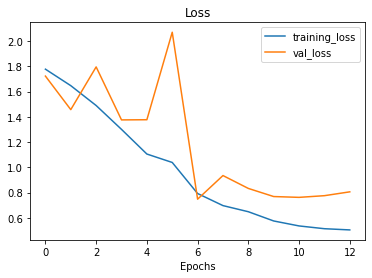

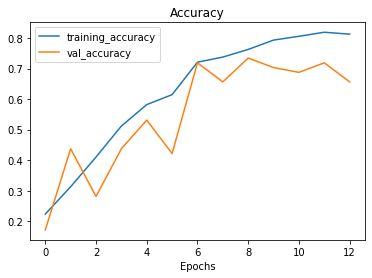

In [ ]:
plot_loss_curves(fine_tune_model)

## Saving model


In [ ]:
# path
m_path = '/content/drive/MyDrive/XYZ_Company'
sav_model = os.path.join(m_path, 'my_saved_model')
os.mkdir(sav_model)

In [ ]:
model_fine_tune.save('/content/drive/MyDrive/XYZ_Company/my_saved_model/my_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/XYZ_Company/my_saved_model/my_model/assets


# Prediction using the final model

In [ ]:
def pred_classes(pth, df):

  img_path = [os.path.join(pth,i) for i in df_test['Image_Path'].values]
  #image = []

  for i, name in enumerate(img_path):
    #load the image
    #print(i, name)
    
    my_image = load_img(name, target_size=(224, 224))

    #preprocess the image
    my_image = img_to_array(my_image)
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    my_image = preprocess_input(my_image)
    
    #make the prediction
    pred = model_fine_tune.predict(my_image)

    predi=pred.copy()
    predi = np.amax(predi, axis=1)
    pred = np.argmax(pred,axis=1)
    
    labels = (train_data.class_indices)
    labels = dict((v,k) for k,v in labels.items())

    pred = [labels[k] for k in pred]
    
    #print(pred[0], predi[0])

    df_test.loc[i,'pred_class'] = pred[0]
    df_test.loc[i,'confidence'] = predi[0]

  return df_test
     

In [ ]:
pth = '/content/drive/MyDrive/XYZ_Company/Dataset'
out = pred_classes(pth, df_test)
print(out.head())

               Image_Path  Class pred_class  confidence
0  Testing/2015_00417.jpg    NaN    Bicycle         1.0
1  Testing/2015_07261.jpg    NaN      Table         1.0
2  Testing/2015_01083.jpg    NaN    Bicycle         1.0
3  Testing/2015_06722.jpg    NaN      Table         1.0
4  Testing/2015_01124.jpg    NaN  Motorbike         1.0


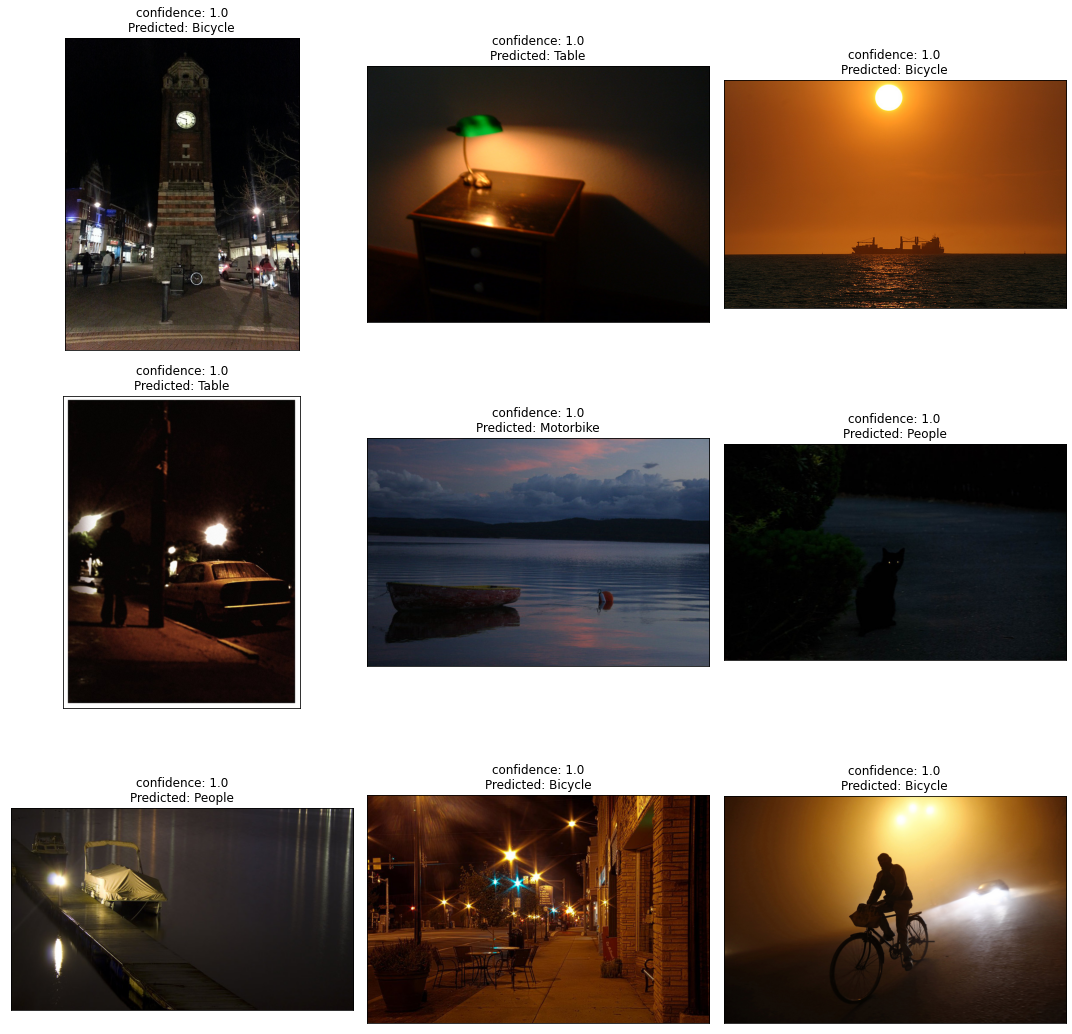

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  im_pth = os.path.join(pth, out['Image_Path'][i])

  ax.imshow(plt.imread(im_pth))
  ax.set_title(f"confidence: {out['confidence'][i]}\nPredicted: {out['pred_class'][i]}")

plt.tight_layout()
plt.show()

## Output file for Submission   

In [ ]:
koutput_path = os.path.join('/content/drive/MyDrive/XYZ_Company','output')
if not os.path.exists(output_path):
  os.makedirs(output_path)

In [ ]:
submission_file = out.copy()
submission_file.drop(columns=['Class', 'confidence'], axis=1, inplace=True)
submission_file.rename(columns = {'pred_class':'Class'}, inplace = True)
submission_file.to_csv(os.path.join('/content/drive/MyDrive/XYZ_Company/output','submission_file.csv'), index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/XYZ_Company/output/submission_file.csv')
df.head()

,Image_Path,Class
0,Testing/2015_00417.jpg,Bicycle
1,Testing/2015_07261.jpg,Table
2,Testing/2015_01083.jpg,Bicycle
3,Testing/2015_06722.jpg,Table
4,Testing/2015_01124.jpg,Motorbike
